# MLP Results (Paper)

Train an MLP regressor or classifier to learn the AoA estimation error.

## Config parameters

In [2]:
experiment = 1
experiment_set_name = 'mlp_paper'

In [1]:
## Data analysis parameters

# Set to true to discard any data with rotation values >= 360
restrict_single_rot = False
# Compute rotation angles modulo 360
wrap_to_single_rot = True

# Number of bins for binned analysis
nbins = 50

# Dataset to use if plot is restricted to single dataset
target = '300cm'
#target = '2m'

## Data input parameters

# How many measurements were collected at each angle
twr_per_angle = 5

# Input files
input_data = ('cache_config_rotation.csv', 'processed_data_cache_rotation.h5')

# Minimal cache version supported by this analysis script
cache_min_version = 3  # complex sts values required

# True: Load separate datasets into `dataframes` dictionary and combined dataset into `df_full`
# False: Load only combined dataset into `df_full`
get_dataframes = False

# Set to None to get distance from measurement title, otherwise the value given here will be set as distance
fixed_distance = None

# configure used ml libs
USE_XGB = False
USE_TF = False

# version of setup copied from setup notebook
setup_version = 16

## Library imports

In [3]:
# general python imports
import os
import csv
import math
import random
import warnings
import collections
from fractions import Fraction
from collections import OrderedDict

# data processing
import numpy as np
from numpy.polynomial import Polynomial

import pandas as pd

import scipy

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
#import matplotlib.cm as cm => available as plt.cm
from matplotlib import widgets as plt_widgets
from matplotlib.projections import get_projection_class
import matplotlib.patches as patches

# learning
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score
from sklearn.neural_network import MLPClassifier, MLPRegressor

if USE_XGB:
    import xgboost as xgb

if USE_TF:
    import tensorflow as tf
    from tensorflow import keras
    import keras_tuner

# helper functions
from tqdm.notebook import trange, tqdm  # progress bars
import joblib  # persisting sklearn models

## Matplotlib configuration

In [4]:
# better backend for non-interactive plots
%matplotlib inline

# backend for interactive plots
#%matplotlib widget

plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 72
plt.rcParams["savefig.dpi"] = 120
plt.rcParams['axes.linewidth'] = 2  # thicker borders
plt.rcParams.update({'font.size': 12})  # uniform font size
plt.rcParams['svg.fonttype'] = 'none'  # make text available in svg

## Constants and general configration

In [5]:
## Physics and DW3000 properties

# Speed of light (m/s)
c = 299792458

# Units of the TDOA measurement
tdoa_units = 1/(128*499.2*1e6)
tdoa_ns = 1e-9/tdoa_units

In [6]:
## Parameters for AoA estimation

# Center frequency channel 5 (Hz)
freq = 6489.6*1e6

# Wavelength channel 5 (m)
l = c/freq

# Distance between antennas
#d = 0.023
d = 0.0231 # if we have 0.023 here l/(2*d) > 1 which makes arcsin impossible

## Data Input

Run "parse and cache" script to generate a HDF5 cache file. Since the parsing of text files takes so long this script only works with the cached data. If new data fields are required change the cache creation and rebuild the cache file.

The cache config csv file is read and compared to the values in the cache to make sure the correct data is read.

HDF locking is disable to allow reading here while the chaching script is still running. **Make sure the file is fully written before reading it here.**

In [7]:
def load_dataframes(config_file, cache_file, verbose=True):
    with open(config_file, newline='') as f:
        reader = csv.reader(f, delimiter=';')
        files = list(reader)[1:]  # skip header

    log_files = OrderedDict()
    for entry in files:
        if not entry:
            continue
        # entry: (title, filename, description)
        log_files[entry[0]] = (entry[1], entry[2])

    print('Read configuration:', log_files.keys())
    print()

    dataframes = OrderedDict()

    # Do not lock HDF file to allow reading in another process
    os.environ['HDF5_USE_FILE_LOCKING'] = '0'

    datapoints = 0
    with pd.HDFStore(cache_file, mode='r') as store:
        for title, (filename, description) in log_files.items():
            info_df = store.get('cache_'+title+'/info')
            df = store.get('cache_'+title+'/df')
            if (title == info_df.title[0]
                and filename == info_df.file_name[0]):
                print(title, '=>', info_df.description[0])
            else:
                print(title, '=>', 'ERROR stored data does not match configuration')
            # get cache version, it is assumed to be the same for all dataframes in the file
            try:
                cache_version = info_df.version[0]
            except AttributeError:
                cache_version = 2
            df.info(memory_usage='deep')
            print()
            datapoints += len(df)
            dataframes[title] = df

    print(f'Read {datapoints} datapoints from {len(log_files)} experiments.')
    return cache_version, dataframes

## Data Preprocessing

In [8]:
def df_restrict_to_one_rotation(dataframes):
    '''Restrict data to one single rotation (rotation values 0 to 359)'''
    for title in dataframes:
        df = dataframes[title]
        # create a copy of the dataframes to avoid annoying assignment/copy warnings later
        dataframes[title] = df[(0 <= df.rotation) & (df.rotation < 360)].copy()

In [9]:
def df_wrap_to_one_rotation(dataframes):
    '''Wrap data to one single rotation (rotation values 0 to 359, i.e. modulo 360)'''
    for title in dataframes:
        df = dataframes[title]
        # create a copy of the dataframes to avoid annoying assignment/copy warnings later
        df.rotation = df.rotation % 360.
        dataframes[title] = df.copy()

In [10]:
def df_add_unwrapped_pdoa(dataframes):
    '''Unwrap PDoA values so they don't overflow at +/- pi anymore.

    Note: this needs access to the original/true rotation information, therefore
          it can't be computed on the device!

    Column added:
    - pdoa_fixed: "Unwrapped" PDoA values
    '''
    for df in dataframes.values():
        df['pdoa_fixed'] = df.pdoa
        df.loc[(df.pdoa > 1)  & (45 < df.rotation)  & (df.rotation < 155), ('pdoa_fixed', '')] -= 2*math.pi
        df.loc[(df.pdoa < -1) & (200 < df.rotation) & (df.rotation < 361), ('pdoa_fixed', '')] += 2*math.pi

In [11]:
def get_bins(nbins, *, borders=False, centers=False, bins=False):
    if sum([borders, centers, bins]) != 1:
        raise ValueError('Exactly one of bins, borders, centers has to be True')

    bin_borders = np.linspace(-1.5*np.pi, 1.5*np.pi, nbins)
    if borders:
        return bin_borders

    bin_centers = (bin_borders[:-1] + bin_borders[1:])/2
    if centers:
        return bin_centers

    return np.array(list(zip(bin_borders[:-1], bin_borders[1:])))


def df_add_pdoa_bins(dataframes, nbins):
    '''Put every measurement into a bin based on the PDoA or unwrapped PDoA value.

    The bins are evenly spaced over (-1.5 pi, 1.5 pi), i.e. the potential unwrapped
    PDoA range. The Bins for both original and unwrapped PDoA values are identical.

    Note: needs to be run after `df_add_unwrapped_pdoa` to get the pdoa_fixed column.

    Columns added:
    - pdoa_bins: Bin number of the (original) PDoA value of the sample
    - pdoa_fixed_bins: Bin number of the unwrapped PDoA value of the sample

    :param nbins: Number of bins to create
    '''
    bin_borders = get_bins(nbins, borders=True)

    for df in dataframes.values():
        df['pdoa_bins'] = np.digitize(df.pdoa, bin_borders)
        df['pdoa_fixed_bins'] = np.digitize(df.pdoa_fixed, bin_borders)

In [12]:
def df_add_aoa_estimate(dataframes):
    '''Compute angle of arrival (AoA) estimate "theta"

    Column added:
    - theta: Computed angle of arrival.
    '''
    for df in dataframes.values():
        df['theta'] = np.arcsin(df.pdoa*l/(2*math.pi*d))

In [13]:
def df_add_front_back(dataframes):
    '''Add column showing if signals originated at the front or back of receiver.

    Columns added:
    - fb: Categorical with 'front' or 'back' as options
    - rotation_fb: Rotation in (-90, 90) with 0 at original 0 for the front and 0 at original 180 for the back

    Note: +/-90 deg (90 an 270) is excluded from both (fb = NaN)!
    '''
    for df in dataframes.values():
        df['rotation_fb'] = df.rotation
        # Original rotations of 90 and 270 degrees are not included as front or back
        df.loc[df.rotation == 90, 'rotation_fb'] = np.nan
        df.loc[df.rotation == 270, 'rotation_fb'] = np.nan

        # "back" side of receiver
        df.loc[(90 < df.rotation) & (df.rotation < 270), 'fb'] = 'back'
        ## move rotation values 90 < r < 270 to -90 < r < 90
        ## this also moves 270 <= r < 360 to 90 <= r < 180
        #df.loc[df.rotation_fb > 90, ('rotation_fb', '')] -= 180

        # "front" side of receiver
        df.loc[(df.rotation < 90) | (270 < df.rotation), 'fb'] = 'front'
        ## move rotation values 270 < r < 360 to -90 < r < 0, but those values have
        ## already been moved to 90 < r < 180 in the previous step
        #df.loc[df.rotation_fb > 90, ('rotation_fb', '')] -= 180

        # move rotation values, s.t. front goes from -90 to 90, back is not changed
        df.loc[(df.fb == 'front') & (df.rotation > 270), ('rotation_fb', '')] -= 360

        cat_type = pd.CategoricalDtype(categories=['front', 'back'], ordered=False)
        df['fb'] = df['fb'].astype(cat_type)

In [14]:
def add_cir_abs(dataframes):
    '''Add columns for CIR absolute values.

    Note: Only relevant for cache_version > 2, where there the complex CIR columns
          replaced the absolute value columns.

    Columns added:
    - cir_sts1_abs: Absolute value of STS1 CIR
    - cir_sta2_abs: Absolute value of STS2 CIR
    '''
    for title in dataframes.keys():
        df = dataframes[title]
        df_abs = df[['cir_sts1', 'cir_sts2']].abs()
        df_abs = df_abs.rename(columns={'cir_sts1': 'cir_sts1_abs', 'cir_sts2': 'cir_sts2_abs'}, level=0)
        dataframes[title] = pd.concat([df, df_abs], axis=1)

In [15]:
def preprocess(dataframes, version, restrict_single_rot=False, wrap_to_single_rot=False, nbins=None):
    '''Run all preprocessing functions.

    :param dataframes: dict of DataFrames to be modified in place
    :param restrict_single_rot: Pass True to apply df_restrict_to_one_rotation
    :param nbins: See df_add_pdoa_bins
    '''

    if restrict_single_rot:
        df_restrict_to_one_rotation(dataframes)

    if wrap_to_single_rot:
        df_wrap_to_one_rotation(dataframes)

    print('Max rotation value:', [df.rotation.max() for df in dataframes.values()])

    df_add_unwrapped_pdoa(dataframes)

    if nbins:
        df_add_pdoa_bins(dataframes, nbins)

    df_add_aoa_estimate(dataframes)
    df_add_front_back(dataframes)

    if version > 2:
        add_cir_abs(dataframes)

    print('AoA estimation statistics:')
    for title in dataframes:
        df = dataframes[title]
        print(f'- {title:5}: {np.rad2deg(np.min(df.theta)):.3f}, deg to',
              f'{np.rad2deg(np.max(df.theta)):.3f} deg')

In [16]:
def merge_dataframes(dataframes, fixed_distance=None):
    '''Merge dictionary of dataframes into one large dataframe.

    The title (key in the input dictionary) is used to compute the true distance
    and both are added as columns.

    Columns added:
    - title: Title of the original data (key in input dict)
    - distance_m: Distance in meters computed from the title.
    '''
    titles = []
    for (title, df) in dataframes.items():
        if fixed_distance is None:
            # convert title with ...m or ...cm into a number in m
            if title.endswith('cm'):
                distance = int(title[:-2])/100
            else:
                distance = int(title[:1])
        else:
            distance = fixed_distance
        titles.append((distance, title))
        df['title'] = title
        df['distance_m'] = distance

    # concatenate dataframes and make the title column ordered categorical data
    df_full = pd.concat(dataframes.values(), ignore_index=True)
    cat_type = pd.CategoricalDtype(categories=[t[1] for t in sorted(titles)], ordered=True)
    df_full['title'] = df_full['title'].astype(cat_type)
    df_full.info(memory_usage='deep')
    return df_full

In [17]:
#def load_and_prepare(cache_config, cache_file, restrict_single_rot=False, nbins=50):
def load_and_prepare(cache_config, cache_file, get_dataframes=False):
    '''Load, preprocess and merge dataframes.

    :param cache_config: Data cache configuration file.
    :param cache_file: Data cache file
    '''
    version, dataframes = load_dataframes(cache_config, cache_file)
    if version < cache_min_version:
        warnings.warn(f'Loading cache version {version} data, minimal required set to {cache_min_version}')

    preprocess(dataframes, version, restrict_single_rot, wrap_to_single_rot, nbins)  # parameters taken from global configuration!
    df_full = merge_dataframes(dataframes, fixed_distance)
    if get_dataframes:
        return dataframes, df_full
    else:
        return df_full

## Optional preprocessing functions

In [18]:
def split_complex_columns(df, columns, levels=3):
    '''Split complex columns `columns` into real and imaginary parts.'''
    df_split_cir = df[columns].agg([np.real, np.imag])
    df_split_cir.rename(columns={c: c + '_split' for c in columns}, inplace=True)

    if len(df.columns.levels) < levels:
        df = df.copy()
        # add multiindex level to dataframe to fit the new split real/image level
        df.columns = pd.DataFrame(data=1, index=df.columns.copy(), columns=['']).stack().index
    return pd.concat([df, df_split_cir], axis=1)

## Plot helper functions

In [19]:
def axis_pi_formatter(axis, divisor=4, frac=False, indexed_values=None):
    '''Format axis in steps of fractions of pi.

    :param axis: Axis to be formatted. Either Axes instance (e.g. plt.gca()) to format the
                 the yaxis or specific axis to be formatted (e.g. plt.gca().xaxis)
    :param divisor: Divisions of pi to get ticks (default 4)
    :param frac: Format as fraction instead fo float (default False)
    '''
    if isinstance(axis, plt.Axes):
        axis = axis.yaxis

    #get_val = lambda v: (v if indexed_values is None else indexed_values[v])
    def get_val(v):
        #print(v)
        return v

    def format_frac(val):
        f = Fraction(val).as_integer_ratio()
        if f[1] == 1:
            return f'${f[0]}$'
        else:
            return f'$\\frac{{{f[0]}}}{{{f[1]}}}$'

    if frac:
        axis.set_major_formatter(plt.FuncFormatter(
            lambda val, pos: f'{format_frac(get_val(val)/np.pi)}$\\pi$' if val !=0 else '0'
        ))
    else:
        axis.set_major_formatter(plt.FuncFormatter(
           lambda val, pos: '{:.3g}$\\pi$'.format(get_val(val)/np.pi) if val !=0 else '0'
        ))

    axis.set_major_locator(plt.MultipleLocator(base=np.pi/divisor))

In [20]:
# source: https://stackoverflow.com/a/49601444
import matplotlib.colors as mc
import colorsys

def adjust_lightness(color, amount=0.5):
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

In [21]:
from itertools import islice, cycle, chain

def makexticks(ax, step=90):
    #twr_per_angle = 5 => defined above as global parameter
    tick_count = int((ax.get_xlim()[1])//(step*twr_per_angle))+1
    xticks = [i*step*twr_per_angle for i in range(0, tick_count)]
    labels = list(islice(cycle(chain(range(0, 360, 90), range(360, 0, -90))), tick_count))
    ax.set_xticks(xticks)
    ax.set_xticklabels(labels)

## Persistency / Output

In [22]:
def get_output_folder(*sub):
    folder = os.path.join('output', experiment_set_name, f'{experiment_set_name}_{experiment:02}', *sub)
    os.makedirs(folder, exist_ok=True)
    return folder

In [23]:
def save_plot(name, group=''):
    '''Save a figure into a subfolder for the experiment.'''
    folder = get_output_folder(group)
    plt.savefig(os.path.join(folder, name + '.png'), bbox_inches='tight')
    plt.savefig(os.path.join(folder, name + '.svg'), bbox_inches='tight')

In [24]:
def save_model(model, name, txt=None):
    folder = get_output_folder('_models', name)
    if USE_TF and isinstance(model, keras.Model):
        model.save(os.path.join(folder, name))
        keras.utils.plot_model(model, os.path.join(folder, name + '.png'), show_shapes=True)
    else:
        joblib.dump(model, os.path.join(folder, name + '.pkl'))

    if txt:
        with open(os.path.join(folder, name + '.txt'), 'wt') as f:
            f.write(txt)

In [25]:
def load_model(name, model_type='sklearn'):
    folder = get_output_folder('_models', name)
    if model_type == 'sklearn':
        return joblib.load(os.path.join(folder, name + '.pkl'))
    else:
        raise ValueError('Not supported model type.')

In [26]:
logfile = os.path.join(get_output_folder(), 'ipython_log.log')
%logstart -o -t $logfile

Activating auto-logging. Current session state plus future input saved.
Filename       : output/mlp_paper/mlp_paper_01/ipython_log.log
Mode           : backup
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


## Load dataset

In [27]:
if get_dataframes:
    dataframes, df_full = load_and_prepare(*input_data, get_dataframes=True)
else:
    df_full = load_and_prepare(*input_data)

Read configuration: odict_keys(['50cm', '100cm', '150cm', '200cm', '250cm', '300cm', '350cm', '400cm', '450cm', '500cm', '550cm'])

50cm => Distance 50cm, one full turn, 5 samples per 1 degree rotation step, LOS
<class 'pandas.core.frame.DataFrame'>
Index: 1905 entries, 0 to 1904
Columns: 218 entries, ('timestamp', '') to ('cir_sts2', 99)
dtypes: complex128(210), float64(4), int64(4)
memory usage: 6.2 MB

100cm => Distance 100cm, one full turn, 5 samples per 1 degree rotation step, LOS
<class 'pandas.core.frame.DataFrame'>
Index: 1780 entries, 0 to 1779
Columns: 218 entries, ('timestamp', '') to ('cir_sts2', 99)
dtypes: complex128(210), float64(4), int64(4)
memory usage: 5.8 MB

150cm => Distance 150cm, one full turn, 5 samples per 1 degree rotation step, LOS
<class 'pandas.core.frame.DataFrame'>
Index: 1804 entries, 0 to 1803
Columns: 218 entries, ('timestamp', '') to ('cir_sts2', 99)
dtypes: complex128(210), float64(4), int64(4)
memory usage: 5.9 MB

200cm => Distance 200cm, one full

In [28]:
df_full

timestamp number rotation      pdoa tdoa  dist_mm rx_power_level  \
                                                                          
0       14.01324      2      0.0 -0.251465   -1  7131221     -58.566101   
1       14.20220      4      0.0 -0.291504    2  7131252     -55.118826   
2       14.39129      6      0.0 -0.406250    6  7131294     -58.566101   
3       14.58020      8      0.0 -0.316895   -7  7131123     -58.108526   
4       14.76918     10      0.0 -0.296387   -6  7131169     -58.108526   
...          ...    ...      ...       ...  ...      ...            ...   
19875  393.62131   3589      0.0 -0.076660    3  7132072     -73.118826   
19876  393.82034   3591      0.0 -0.132324    0  7132185     -75.694599   
19877  394.02096   3593      0.0 -0.173340   -5  7132095     -75.694599   
19878  394.22085   3595      0.0 -0.063965    3  7132225     -73.118826   
19879  394.48833   3597      1.0 -0.255371   -9  7132041     -76.108526   

      fp_power_level          cir_sts1                    ...  cir_sts2_abs  \
                                    -5                -4  ...            92   
0         -47.074083  10240.0+ 9472.0j   5888.0+10240.0j  ...   7247.664796   
1         -43.617284   6654.0+ 6143.0j   2558.0+ 6143.0j  ...  14965.278380   
2         -46.801459  11263.0+ 3838.0j   8191.0+  256.0j  ...   8737.289339   
3         -46.568244    767.0+ 4096.0j    510.0+ 4609.0j  ...  16433.923938   
4         -46.447449  11520.0+14848.0j  11520.0+ 3072.0j  ...  11920.376043   
...              ...               ...               ...  ...           ...   
19875     -62.111808   4352.0+ 1536.0j   8702.0+ 3841.0j  ...  13361.600091   
19876     -64.313718    257.0+  255.0j   4350.0+ 1535.0j  ...   4126.884055   
19877     -64.434145   2814.0+12543.0j   2048.0+18432.0j  ...  12000.064083   
19878     -61.256190  10753.0+17153.0j   6913.0+ 4865.0j  ...  10100.170543   
19879     -64.699736   6143.0+ 4094.0j   4863.0+ 4608.0j  ...   2996.403177   

                                                                             \
                 93            94            95            96            97   
0       7461.526184   8507.969264  13119.687877   2985.790683   7421.896590   
1      13473.482104  12394.207679  12194.309493  12293.332176  13066.035359   
2      21681.552712  25213.075973  11636.037814   5837.172261  11151.001614   
3      17220.460505   9659.548695  14427.138871   9276.247517   1949.637915   
4      13349.102329   6104.624231  12139.772691   9957.708973   5100.763864   
...             ...           ...           ...           ...           ...   
19875  17847.553586  21639.194070  11019.900544   7059.972025  10503.997144   
19876  16487.423722  21086.628299  16385.000000  14654.078613  15632.696153   
19877  16389.967816  12553.955432  13398.220964   2755.533524   6802.691379   
19878  12676.524445  18003.917796  14982.015886   9564.949346   6191.813951   
19879   5099.208272   5118.000098  11418.553411   8720.455149   4614.551007   

                                   title distance_m  
                 98            99                    
0      13843.375492  15670.527911   50cm        0.5  
1      19315.704699  20026.989789   50cm        0.5  
2       8037.575816  13215.651327   50cm        0.5  
3       9811.849163  25349.171190   50cm        0.5  
4      11859.184458   8195.499497   50cm        0.5  
...             ...           ...    ...        ...  
19875  18219.286622  18944.729742  550cm        5.5  
19876  11112.458099   2768.231385  550cm        5.5  
19877  14084.763008   4469.416629  550cm        5.5  
19878   7283.990390  16714.448989  550cm        5.5  
19879   6104.330676   8825.737193  550cm        5.5  

[19880 rows x 436 columns]

In [29]:
if get_dataframes:
    print(dataframes.keys())

--- End of setup from setup and data input script ---

# Data Analysis

### Input processing

In [30]:
df_full

timestamp number rotation      pdoa tdoa  dist_mm rx_power_level  \
                                                                          
0       14.01324      2      0.0 -0.251465   -1  7131221     -58.566101   
1       14.20220      4      0.0 -0.291504    2  7131252     -55.118826   
2       14.39129      6      0.0 -0.406250    6  7131294     -58.566101   
3       14.58020      8      0.0 -0.316895   -7  7131123     -58.108526   
4       14.76918     10      0.0 -0.296387   -6  7131169     -58.108526   
...          ...    ...      ...       ...  ...      ...            ...   
19875  393.62131   3589      0.0 -0.076660    3  7132072     -73.118826   
19876  393.82034   3591      0.0 -0.132324    0  7132185     -75.694599   
19877  394.02096   3593      0.0 -0.173340   -5  7132095     -75.694599   
19878  394.22085   3595      0.0 -0.063965    3  7132225     -73.118826   
19879  394.48833   3597      1.0 -0.255371   -9  7132041     -76.108526   

      fp_power_level          cir_sts1                    ...  cir_sts2_abs  \
                                    -5                -4  ...            92   
0         -47.074083  10240.0+ 9472.0j   5888.0+10240.0j  ...   7247.664796   
1         -43.617284   6654.0+ 6143.0j   2558.0+ 6143.0j  ...  14965.278380   
2         -46.801459  11263.0+ 3838.0j   8191.0+  256.0j  ...   8737.289339   
3         -46.568244    767.0+ 4096.0j    510.0+ 4609.0j  ...  16433.923938   
4         -46.447449  11520.0+14848.0j  11520.0+ 3072.0j  ...  11920.376043   
...              ...               ...               ...  ...           ...   
19875     -62.111808   4352.0+ 1536.0j   8702.0+ 3841.0j  ...  13361.600091   
19876     -64.313718    257.0+  255.0j   4350.0+ 1535.0j  ...   4126.884055   
19877     -64.434145   2814.0+12543.0j   2048.0+18432.0j  ...  12000.064083   
19878     -61.256190  10753.0+17153.0j   6913.0+ 4865.0j  ...  10100.170543   
19879     -64.699736   6143.0+ 4094.0j   4863.0+ 4608.0j  ...   2996.403177   

                                                                             \
                 93            94            95            96            97   
0       7461.526184   8507.969264  13119.687877   2985.790683   7421.896590   
1      13473.482104  12394.207679  12194.309493  12293.332176  13066.035359   
2      21681.552712  25213.075973  11636.037814   5837.172261  11151.001614   
3      17220.460505   9659.548695  14427.138871   9276.247517   1949.637915   
4      13349.102329   6104.624231  12139.772691   9957.708973   5100.763864   
...             ...           ...           ...           ...           ...   
19875  17847.553586  21639.194070  11019.900544   7059.972025  10503.997144   
19876  16487.423722  21086.628299  16385.000000  14654.078613  15632.696153   
19877  16389.967816  12553.955432  13398.220964   2755.533524   6802.691379   
19878  12676.524445  18003.917796  14982.015886   9564.949346   6191.813951   
19879   5099.208272   5118.000098  11418.553411   8720.455149   4614.551007   

                                   title distance_m  
                 98            99                    
0      13843.375492  15670.527911   50cm        0.5  
1      19315.704699  20026.989789   50cm        0.5  
2       8037.575816  13215.651327   50cm        0.5  
3       9811.849163  25349.171190   50cm        0.5  
4      11859.184458   8195.499497   50cm        0.5  
...             ...           ...    ...        ...  
19875  18219.286622  18944.729742  550cm        5.5  
19876  11112.458099   2768.231385  550cm        5.5  
19877  14084.763008   4469.416629  550cm        5.5  
19878   7283.990390  16714.448989  550cm        5.5  
19879   6104.330676   8825.737193  550cm        5.5  

[19880 rows x 436 columns]

In [31]:
time_stats = df_full.groupby('title').timestamp.agg(['count', 'min', 'max'])
time_stats['time_per_meas'] = (time_stats['max']-time_stats['min'])/time_stats['count']
time_stats['meas_per_second'] = 1/time_stats['time_per_meas']
time_stats

/tmp/ipykernel_2269/4160669346.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_stats = df_full.groupby('title').timestamp.agg(['count', 'min', 'max'])


,count,min,max,time_per_meas,meas_per_second
title,,,,,
50cm,1905,14.01324,405.29944,0.205400,4.868559
100cm,1780,9.36769,418.21402,0.229689,4.353714
150cm,1804,11.31180,410.14705,0.221084,4.523171
200cm,1799,10.55394,454.53680,0.246794,4.051958
250cm,1797,15.56403,404.59911,0.216491,4.619121
300cm,1796,8.15193,392.98017,0.214270,4.667017
350cm,1803,10.58653,408.42947,0.220656,4.531939
400cm,1797,16.03803,401.86946,0.214709,4.657474
450cm,1804,9.58464,394.41303,0.213320,4.687804


In [32]:
df_full = split_complex_columns(df_full, ['cir_sts1', 'cir_sts2'])

/tmp/ipykernel_2269/843029871.py:3: FutureWarning: using <function real at 0x7f9f346747c0> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  df_split_cir = df[columns].agg([np.real, np.imag])
/tmp/ipykernel_2269/843029871.py:3: FutureWarning: using <function imag at 0x7f9f34674900> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  df_split_cir = df[columns].agg([np.real, np.imag])


In [33]:
rotation_full = -np.deg2rad(df_full.rotation)
rotation_full[rotation_full < -np.pi] += 2*np.pi  # let rotation values go from -pi to pi, not 0 to 2pi
df_full['rotation_rad'] = rotation_full

In [34]:
df_full.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19880 entries, 0 to 19879
Columns: 857 entries, ('timestamp', '', '') to ('rotation_rad', '', '')
dtypes: category(2), complex128(210), float64(640), int64(5)
memory usage: 161.6 MB


## I/O definition

### Potential input variables:
* PDoA
* TDoA
* CIR: cir_sts1_abs, cir_sts2_abs, etc.

### Potential target variables:
* Distance estimation error
* AoA estimation error

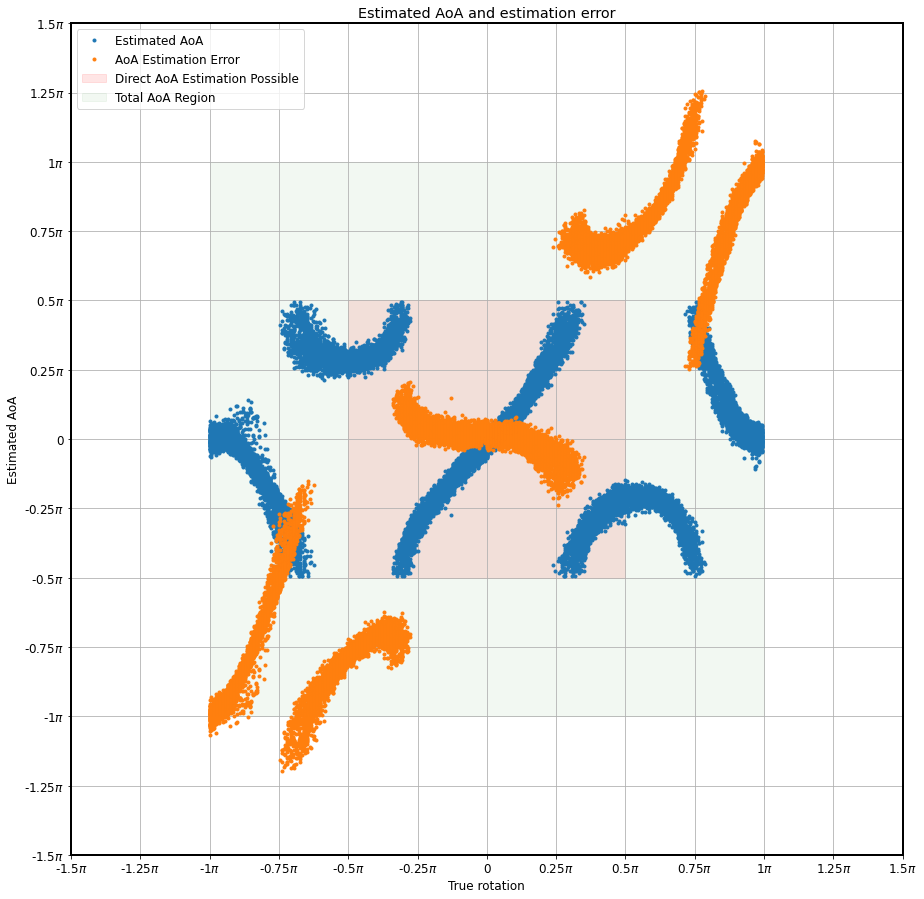

In [35]:
fig, ax = plt.subplots(figsize=(15, 15))

df = df_full

plt.plot(df.rotation_rad, df.theta, '.', label='Estimated AoA')

plt.plot(df.rotation_rad, df.rotation_rad-df.theta, '.', label='AoA Estimation Error')

#plt.vlines([-0.5*np.pi, 0.5*np.pi], -1.25*np.pi, 1.25*np.pi, color='red', linestyle='dotted')

rect = patches.Rectangle([-0.5*np.pi, -0.5*np.pi], np.pi, np.pi, edgecolor='red', facecolor='red', alpha=0.1, label='Direct AoA Estimation Possible')
ax.add_patch(rect)
rect = patches.Rectangle([-np.pi, -np.pi], 2*np.pi, 2*np.pi, edgecolor='green', facecolor='green', alpha=0.05, label='Total AoA Region')
ax.add_patch(rect)

plt.ylim(-1.5*np.pi, 1.5*np.pi)
plt.xlim(-1.5*np.pi, 1.5*np.pi)
ax.set_aspect(1)

axis_pi_formatter(ax.xaxis)
axis_pi_formatter(ax.yaxis)
plt.grid()
plt.legend()

plt.title('Estimated AoA and estimation error')
plt.xlabel('True rotation')
plt.ylabel('Estimated AoA')

save_plot('aoa_error')
plt.show()

### Select input and target variables

In [36]:
def filter_outliers(df):
    ok_idx = (df.tdoa > -tdoa_ns) & (df.tdoa < tdoa_ns) & (df.dist_mm > 1000)
    print(f'All: {len(df)}, keep: {len(df[ok_idx])}, discard: {len(df[~ok_idx])}')
    return df[ok_idx]

In [37]:
#data = df.loc[(90 <= df.rotation) & (df.rotation <= 270), ['pdoa', 'tdoa', 'cir_sts1_abs', 'rotation', 'theta']]
data = df_full.loc[:, ['pdoa', 'tdoa', 'rx_power_level', 'fp_power_level', 'cir_sts1_split', 'cir_sts2_split',
                       'cir_sts1_abs', 'cir_sts2_abs', 'dist_mm', 'rotation', 'theta', 'rotation_rad', 'distance_m']]

data['aoa_est_error'] = data.rotation_rad-data.theta
data['power'] = data.fp_power_level/data.rx_power_level

data = filter_outliers(data)

data

All: 19880, keep: 19508, discard: 372


pdoa tdoa rx_power_level fp_power_level cir_sts1_split           \
                                                               -5            
                                                             real     imag   
0     -0.251465   -1     -58.566101     -47.074083        10240.0   9472.0   
1     -0.291504    2     -55.118826     -43.617284         6654.0   6143.0   
2     -0.406250    6     -58.566101     -46.801459        11263.0   3838.0   
3     -0.316895   -7     -58.108526     -46.568244          767.0   4096.0   
4     -0.296387   -6     -58.108526     -46.447449        11520.0  14848.0   
...         ...  ...            ...            ...            ...      ...   
19875 -0.076660    3     -73.118826     -62.111808         4352.0   1536.0   
19876 -0.132324    0     -75.694599     -64.313718          257.0    255.0   
19877 -0.173340   -5     -75.694599     -64.434145         2814.0  12543.0   
19878 -0.063965    3     -73.118826     -61.256190        10753.0  17153.0   
19879 -0.255371   -9     -76.108526     -64.699736         6143.0   4094.0   

                                          ...  cir_sts2_abs                \
            -4               -3           ...            97            98   
          real     imag    real     imag  ...                               
0       5888.0  10240.0  1534.0   8447.0  ...   7421.896590  13843.375492   
1       2558.0   6143.0  8960.0   4864.0  ...  13066.035359  19315.704699   
2       8191.0    256.0  8192.0   3840.0  ...  11151.001614   8037.575816   
3        510.0   4609.0  1025.0   6401.0  ...   1949.637915   9811.849163   
4      11520.0   3072.0  2560.0   4862.0  ...   5100.763864  11859.184458   
...        ...      ...     ...      ...  ...           ...           ...   
19875   8702.0   3841.0  7425.0   3841.0  ...  10503.997144  18219.286622   
19876   4350.0   1535.0  5888.0   7680.0  ...  15632.696153  11112.458099   
19877   2048.0  18432.0  5886.0   7679.0  ...   6802.691379  14084.763008   
19878   6913.0   4865.0  5119.0   4350.0  ...   6191.813951   7283.990390   
19879   4863.0   4608.0  2048.0  17664.0  ...   4614.551007   6104.330676   

                     dist_mm rotation     theta rotation_rad distance_m  \
                 99                                                       
                                                                          
0      15670.527911  7131221      0.0 -0.080122    -0.000000        0.5   
1      20026.989789  7131252      0.0 -0.092914    -0.000000        0.5   
2      13215.651327  7131294      0.0 -0.129665    -0.000000        0.5   
3      25349.171190  7131123      0.0 -0.101033    -0.000000        0.5   
4       8195.499497  7131169      0.0 -0.094475    -0.000000        0.5   
...             ...      ...      ...       ...          ...        ...   
19875  18944.729742  7132072      0.0 -0.024402    -0.000000        5.5   
19876   2768.231385  7132185      0.0 -0.042129    -0.000000        5.5   
19877   4469.416629  7132095      0.0 -0.055199    -0.000000        5.5   
19878  16714.448989  7132225      0.0 -0.020360    -0.000000        5.5   
19879   8825.737193  7132041      1.0 -0.081370    -0.017453        5.5   

      aoa_est_error     power  
                               
                               
0          0.080122  0.803777  
1          0.092914  0.791332  
2          0.129665  0.799122  
3          0.101033  0.801401  
4          0.094475  0.799322  
...             ...       ...  
19875      0.024402  0.849464  
19876      0.042129  0.849647  
19877      0.055199  0.851238  
19878      0.020360  0.837762  
19879      0.063916  0.850098  

[19508 rows x 641 columns]

In [38]:
#data = df.loc[(90 <= df.rotation) & (df.rotation <= 270), ['pdoa', 'tdoa', 'cir_sts1_abs', 'rotation', 'theta']]
data = df_full.loc[:, ['pdoa', 'tdoa', 'rx_power_level', 'fp_power_level', 'cir_sts1_split', 'cir_sts2_split', 'cir_sts1_abs', 'cir_sts2_abs', 'dist_mm', 'rotation', 'theta', 'rotation_rad', 'distance_m']]
data['aoa_est_error'] = data.rotation_rad-data.theta
data

pdoa tdoa rx_power_level fp_power_level cir_sts1_split           \
                                                               -5            
                                                             real     imag   
0     -0.251465   -1     -58.566101     -47.074083        10240.0   9472.0   
1     -0.291504    2     -55.118826     -43.617284         6654.0   6143.0   
2     -0.406250    6     -58.566101     -46.801459        11263.0   3838.0   
3     -0.316895   -7     -58.108526     -46.568244          767.0   4096.0   
4     -0.296387   -6     -58.108526     -46.447449        11520.0  14848.0   
...         ...  ...            ...            ...            ...      ...   
19875 -0.076660    3     -73.118826     -62.111808         4352.0   1536.0   
19876 -0.132324    0     -75.694599     -64.313718          257.0    255.0   
19877 -0.173340   -5     -75.694599     -64.434145         2814.0  12543.0   
19878 -0.063965    3     -73.118826     -61.256190        10753.0  17153.0   
19879 -0.255371   -9     -76.108526     -64.699736         6143.0   4094.0   

                                          ...  cir_sts2_abs                \
            -4               -3           ...            96            97   
          real     imag    real     imag  ...                               
0       5888.0  10240.0  1534.0   8447.0  ...   2985.790683   7421.896590   
1       2558.0   6143.0  8960.0   4864.0  ...  12293.332176  13066.035359   
2       8191.0    256.0  8192.0   3840.0  ...   5837.172261  11151.001614   
3        510.0   4609.0  1025.0   6401.0  ...   9276.247517   1949.637915   
4      11520.0   3072.0  2560.0   4862.0  ...   9957.708973   5100.763864   
...        ...      ...     ...      ...  ...           ...           ...   
19875   8702.0   3841.0  7425.0   3841.0  ...   7059.972025  10503.997144   
19876   4350.0   1535.0  5888.0   7680.0  ...  14654.078613  15632.696153   
19877   2048.0  18432.0  5886.0   7679.0  ...   2755.533524   6802.691379   
19878   6913.0   4865.0  5119.0   4350.0  ...   9564.949346   6191.813951   
19879   4863.0   4608.0  2048.0  17664.0  ...   8720.455149   4614.551007   

                                   dist_mm rotation     theta rotation_rad  \
                 98            99                                            
                                                                             
0      13843.375492  15670.527911  7131221      0.0 -0.080122    -0.000000   
1      19315.704699  20026.989789  7131252      0.0 -0.092914    -0.000000   
2       8037.575816  13215.651327  7131294      0.0 -0.129665    -0.000000   
3       9811.849163  25349.171190  7131123      0.0 -0.101033    -0.000000   
4      11859.184458   8195.499497  7131169      0.0 -0.094475    -0.000000   
...             ...           ...      ...      ...       ...          ...   
19875  18219.286622  18944.729742  7132072      0.0 -0.024402    -0.000000   
19876  11112.458099   2768.231385  7132185      0.0 -0.042129    -0.000000   
19877  14084.763008   4469.416629  7132095      0.0 -0.055199    -0.000000   
19878   7283.990390  16714.448989  7132225      0.0 -0.020360    -0.000000   
19879   6104.330676   8825.737193  7132041      1.0 -0.081370    -0.017453   

      distance_m aoa_est_error  
                                
                                
0            0.5      0.080122  
1            0.5      0.092914  
2            0.5      0.129665  
3            0.5      0.101033  
4            0.5      0.094475  
...          ...           ...  
19875        5.5      0.024402  
19876        5.5      0.042129  
19877        5.5      0.055199  
19878        5.5      0.020360  
19879        5.5      0.063916  

[19880 rows x 640 columns]

In [39]:
experiment

1

**PDoA, TDoA, complex CIR and distance estimate => AoA Error, distance**

(was experiment 5)

In [40]:
class CIRScaler2():
    def __init__(self, center_and_scale=[], scale_only=[], scale_min_max=[]):
        self.center_and_scale = center_and_scale
        self.scale_only = scale_only
        self.scale_min_max = scale_min_max

    def fit(self, data):
        self.mean_ = {}
        self.scale_ = {}
        self.offset_ = {}

        for col in self.center_and_scale:
            self.mean_[col] = data[col].values.mean()
            self.scale_[col] = data[col].values.std(ddof=1)
            self.offset_[col] = 0

        for col in self.scale_only:
            self.mean_[col] = 0  # only scale by maximum to preserve shape
            self.scale_[col] = data[col].values.max()
            self.offset_[col] = 0

        for col in self.scale_min_max:
            self.mean_[col] = 0
            data_min = data[col].min()
            self.scale_[col] = data[col].max()-data_min
            self.offset_[col] = data_min

        return self

    def transform(self, data, copy=True):
        if copy:
            data = data.copy()

        for col in self.center_and_scale + self.scale_only + self.scale_min_max:
            data[col] -= self.offset_[col]
            data[col] -= self.mean_[col]
            data[col] /= self.scale_[col]

        return data

    def info(self):
        s = [
            '* CIRScaler2:',
            'Inputs:'
            f'- center_and_scale: {self.center_and_scale}',
            f'- scale_only: {self.scale_only}',
            f'- scale_min_max: {self.scale_min_max}',
            'Fit:',
            f'- Mean {self.mean_}',
            f'- Scale {self.scale_}',
            f'- Offset {self.offset_}',
            '**'
        ]
        return '\n'.join(s)

In [41]:
#X_cols = ['pdoa', 'tdoa', 'rx_power_level', 'fp_power_level', 'cir_sts1_split', 'cir_sts2_split', 'dist_mm']
#y_cols = ['aoa_est_error', 'distance_m']
#prep = CIRScaler2(['pdoa', 'tdoa'], ['cir_sts1_split', 'cir_sts2_split'], ['rx_power_level', 'fp_power_level', 'dist_mm'])

X_cols = ['pdoa', 'tdoa', 'cir_sts1_split', 'cir_sts2_split', 'dist_mm']
y_cols = ['aoa_est_error', 'distance_m']
prep = CIRScaler2(['pdoa', 'tdoa'], ['cir_sts1_split', 'cir_sts2_split'], ['dist_mm'])

End of experiment definitions

In [42]:
X = data[X_cols]
y = data[y_cols if len(y_cols) > 1 else y_cols[0]]

In [43]:
prep.fit(X)
prep.mean_, prep.scale_

({'pdoa': np.float64(-0.07253135512292505),
  'tdoa': np.float64(-4.3428068410462775),
  'cir_sts1_split': 0,
  'cir_sts2_split': 0,
  'dist_mm': 0},
 {'pdoa': np.float64(2.0618995041179766),
  'tdoa': np.float64(19.5323498418778),
  'cir_sts1_split': np.float64(1043198.0),
  'cir_sts2_split': np.float64(1041918.0),
  'dist_mm': np.int64(7132212)})

In [44]:
# helper data for later analysis, not used in learning
meta = data[['rotation_rad', 'theta', 'aoa_est_error']]

In [45]:
# split dataset into training and test
X_train, X_test, y_train, y_test, meta_train, meta_test = train_test_split(X, y, meta, test_size=0.4, random_state=1)

print('Total samples:', len(X))
print('Training samples:', len(X_train))
print('Test samples', len(X_test))

Total samples: 19880
Training samples: 11928
Test samples 7952


In [46]:
print('X')
X_train.info()
print('\ny')
y_train.info()
print('\nmeta')
meta.info()

X
<class 'pandas.core.frame.DataFrame'>
Index: 11928 entries, 11246 to 235
Columns: 423 entries, ('pdoa', '', '') to ('dist_mm', '', '')
dtypes: float64(421), int64(2)
memory usage: 38.6 MB

y
<class 'pandas.core.frame.DataFrame'>
Index: 11928 entries, 11246 to 235
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   (aoa_est_error, , )  11928 non-null  float64
 1   (distance_m, , )     11928 non-null  float64
dtypes: float64(2)
memory usage: 279.6 KB

meta
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19880 entries, 0 to 19879
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   (rotation_rad, , )   19880 non-null  float64
 1   (theta, , )          19880 non-null  float64
 2   (aoa_est_error, , )  19880 non-null  float64
dtypes: float64(3)
memory usage: 466.1 KB


In [47]:
X_train

pdoa tdoa cir_sts1_split                                     \
                                 -5               -4                -3   
                               real     imag    real     imag     real   
11246  2.391113   10         1790.0   1023.0   512.0   6142.0   6911.0   
6437   0.585938   -8         7422.0      1.0  3585.0   3841.0   7679.0   
616   -2.957520  -28         6144.0  10240.0  3840.0   8192.0   4606.0   
8165   0.104980    3         5120.0  21248.0  4864.0  18944.0   5632.0   
1011   1.478027   -2         7424.0    256.0  5376.0   1278.0   1537.0   
...         ...  ...            ...      ...     ...      ...      ...   
10955 -1.349609   11         3582.0   4607.0  1534.0   7679.0    510.0   
17289  0.674805  -23         3326.0   1537.0  6143.0   5630.0  25855.0   
5192  -2.923340  -10         6400.0   3072.0  4096.0   7680.0    510.0   
12172 -1.862793  -29         2817.0    767.0  6144.0   2046.0      1.0   
235   -2.522461   20            0.0   1792.0  1534.0   3327.0      0.0   

                                 ... cir_sts2_split                    \
                     -2          ...             95       96            
          imag     real    imag  ...           imag     real     imag   
11246      0.0    768.0   254.0  ...         3841.0   3841.0   9473.0   
6437    5118.0  13567.0   766.0  ...        11519.0    766.0   8191.0   
616    13311.0  15870.0  7679.0  ...            1.0    511.0   1536.0   
8165    9216.0    512.0  6144.0  ...         1790.0      1.0   8959.0   
1011    5887.0   6142.0  2047.0  ...        10751.0  11774.0  19199.0   
...        ...      ...     ...  ...            ...      ...      ...   
10955   3583.0    768.0  1278.0  ...        15105.0   6401.0   8961.0   
17289    766.0  28159.0  3072.0  ...        28416.0   3584.0  19712.0   
5192    5119.0   7934.0  8449.0  ...         1536.0   6912.0   5376.0   
12172   8193.0   2303.0  3070.0  ...        12545.0   6143.0  11518.0   
235     2560.0   9216.0  4864.0  ...         7936.0   4352.0   2558.0   

                                                             dist_mm  
            97                98                99                    
          real     imag     real     imag     real     imag           
11246   6911.0    256.0  15104.0  13056.0  14336.0  11520.0  7131606  
6437     256.0   5632.0   5376.0   4352.0   3584.0   4352.0  7131416  
616     1792.0   7424.0    254.0    513.0   7425.0   7937.0  7131063  
8165    6912.0    510.0  10495.0  11774.0  12799.0   8446.0  7131030  
1011    1022.0  13311.0   8192.0    768.0   5120.0   9726.0  7131043  
...        ...      ...      ...      ...      ...      ...      ...  
10955   3585.0   4097.0   2305.0   1025.0   5887.0   1024.0  7131618  
17289    510.0  17407.0   3840.0  16896.0   4094.0  24575.0  7131798  
5192    9472.0  13312.0   6912.0  20224.0   4864.0  25856.0  7131242  
12172  12799.0  12286.0   2047.0   8190.0  14337.0   2559.0  7131635  
235     6143.0   5376.0   2816.0  12800.0   4864.0  11008.0  7131130  

[11928 rows x 423 columns]

In [48]:
y_train

,aoa_est_error,distance_m
,,
,,
11246,-2.139015,3.5
6437,2.779469,2.0
616,-0.920227,0.5
8165,-3.087746,2.5
1011,2.267844,0.5
...,...,...
10955,0.199654,3.5
17289,2.558609,5.0


In [49]:
meta_train

,rotation_rad,theta,aoa_est_error
,,,
,,,
11246,-1.274090,0.864925,-2.139015
6437,2.967060,0.187591,2.779469
616,-2.146755,-1.226528,-0.920227
8165,-3.054326,0.033420,-3.087746
1011,2.757620,0.489776,2.267844
...,...,...,...
10955,-0.244346,-0.444000,0.199654
17289,2.775074,0.216464,2.558609


## Preprocess data

In [50]:
# number of samples with more than 1ns TDoA => possibly inaccurate values
len(X_train[(X_train.tdoa < -tdoa_ns) | (X_train.tdoa > tdoa_ns)]), len(X_train)

(149, 11928)

In [51]:
ok_idx = (X_train.tdoa > -tdoa_ns) & (X_train.tdoa < tdoa_ns)
X_train = X_train[ok_idx]
y_train = y_train[ok_idx]
meta_train = meta_train[ok_idx]

In [52]:
# scale X data (column wise) to zero mean and unit variance

#scaler = preprocessing.StandardScaler().fit(X_train)
#scaler.mean_, scaler.scale_

scaler = prep.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Training Regressor

In [53]:
%%time

#regr = MLPRegressor(random_state=1, max_iter=500, hidden_layer_sizes=(100, 100))
#regr = MLPRegressor(random_state=1, max_iter=500, hidden_layer_sizes=(15,))
regr = MLPRegressor(random_state=1, max_iter=500, hidden_layer_sizes=(224,), verbose=1)

regr.fit(X_train_scaled, y_train)
#save_model(regr, 'mlp_regressor_defaults')

#regr = load_model('mlp_regressor_defaults')

regr

Iteration 1, loss = 1.34280971
Iteration 2, loss = 0.87999339
Iteration 3, loss = 0.75606613
Iteration 4, loss = 0.67078970
Iteration 5, loss = 0.60015869
Iteration 6, loss = 0.53845777
Iteration 7, loss = 0.48202117
Iteration 8, loss = 0.43383003
Iteration 9, loss = 0.38950653
Iteration 10, loss = 0.35181902
Iteration 11, loss = 0.32211606
Iteration 12, loss = 0.29455806
Iteration 13, loss = 0.27046357
Iteration 14, loss = 0.25262434
Iteration 15, loss = 0.23897417
Iteration 16, loss = 0.22364434
Iteration 17, loss = 0.20968147
Iteration 18, loss = 0.20170856
Iteration 19, loss = 0.18932030
Iteration 20, loss = 0.18089706
Iteration 21, loss = 0.17576909
Iteration 22, loss = 0.17079333
Iteration 23, loss = 0.16224403
Iteration 24, loss = 0.15658908
Iteration 25, loss = 0.14993242
Iteration 26, loss = 0.14562269
Iteration 27, loss = 0.14293908
Iteration 28, loss = 0.13585218
Iteration 29, loss = 0.13277311
Iteration 30, loss = 0.12759631
Iteration 31, loss = 0.12465188
Iteration 32, los

MLPRegressor(hidden_layer_sizes=(224,), max_iter=500, random_state=1, verbose=1)

In [54]:
regr.coefs_

[array([[-3.27987462e-006,  1.45247461e-001, -8.49466450e-002, ...,
         -2.79472966e-002, -7.56541065e-002,  8.05373875e-004],
        [-4.01832893e-006,  9.77460437e-002, -1.14733687e-003, ...,
          2.46394838e-001, -5.15046766e-004,  3.11329899e-003],
        [ 2.05687248e-137, -1.12360692e-001, -8.44911370e-003, ...,
         -5.69982711e-001,  4.81921893e-002, -9.56553030e-126],
        ...,
        [ 4.89208133e-125, -3.86840142e-002, -6.83306063e-002, ...,
          6.56364470e-001, -6.42575207e-002,  3.24341626e-112],
        [ 1.05390151e-124,  2.27547593e-003,  9.80652904e-002, ...,
          1.72132376e-001,  7.94604595e-002,  1.05181939e-103],
        [-2.53220873e-006, -3.45988394e-002,  7.70747772e-002, ...,
         -9.17860269e-002,  7.78161067e-002,  1.86544097e-003]],
       shape=(423, 224)),
 array([[-3.42726250e-15, -3.43807268e-07],
        [ 7.86323175e-02,  1.10308684e-01],
        [-9.75442630e-03,  1.40143983e-01],
        [ 3.99050470e-01,  6.8808144

In [55]:
import itertools

In [56]:
n_coefs = len(list(itertools.chain.from_iterable(itertools.chain.from_iterable(regr.coefs_))))
n_coefs

95200

In [57]:
224*len(X.columns)+224*len(y.columns) == n_coefs

True

In [58]:
n_intercepts = len(list(itertools.chain.from_iterable(regr.intercepts_)))
n_intercepts

226

In [59]:
n_parameters = (n_coefs+n_intercepts)
var_size = 4  # float
print(f'-> {(n_parameters * var_size)/1024:.0f}kb')

-> 373kb


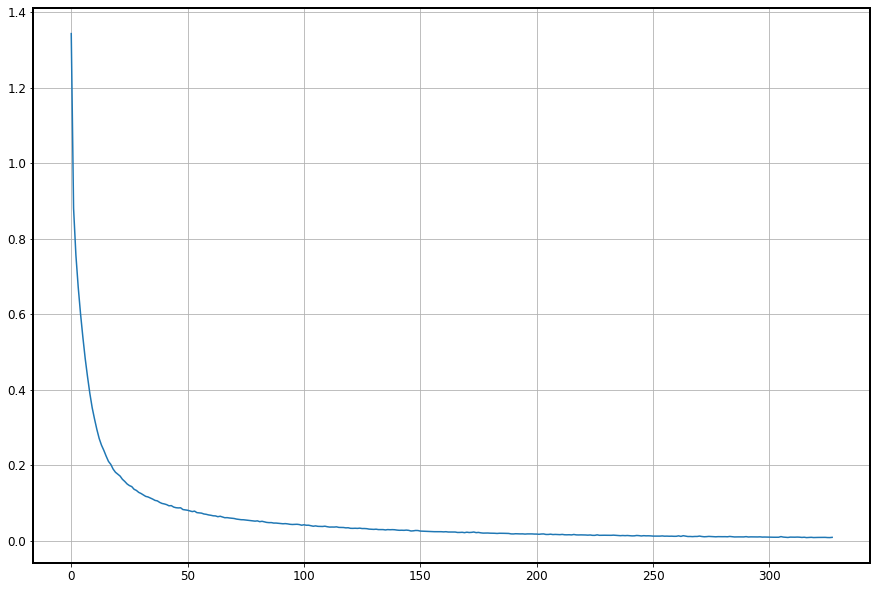

In [60]:
plt.figure()
plt.plot(regr.loss_curve_)
#plt.ylim(0, 1)
plt.grid()
plt.show()

In [61]:
regr.score(X_train_scaled, y_train), regr.score(X_test_scaled, y_test)

(0.9956516433832157, 0.9469180639796317)

### Prediction

In [62]:
y_pred_full = pd.DataFrame(regr.predict(scaler.transform(X)), index=y.index, columns=y.columns)
y_pred_train = pd.DataFrame(regr.predict(scaler.transform(X_train)), index=y_train.index, columns=y_train.columns)
y_pred_test = pd.DataFrame(regr.predict(scaler.transform(X_test)), index=y_test.index, columns=y_test.columns)

In [63]:
y_pred_full.describe()

,aoa_est_error,distance_m
,,
,,
count,19880.000000,19880.000000
mean,0.078866,2.996564
std,2.056793,1.597775
min,-5.600453,0.010845
25%,-2.057291,1.578490
50%,0.115647,2.984298
75%,2.157468,4.466317
max,4.765341,6.950250


In [64]:
mse = np.rad2deg(mean_squared_error(y.aoa_est_error, y_pred_full.aoa_est_error))
mae = np.rad2deg(mean_absolute_error(y.aoa_est_error, y_pred_full.aoa_est_error))
print(f'Full: MSE {mse:6.3f} deg, MAE {mae:6.3f} deg')

mse = np.rad2deg(mean_squared_error(y_train.aoa_est_error, y_pred_train.aoa_est_error))
mae = np.rad2deg(mean_absolute_error(y_train.aoa_est_error, y_pred_train.aoa_est_error))
print(f'Train: MSE {mse:6.3f} deg, MAE {mae:6.3f} deg')

mse = np.rad2deg(mean_squared_error(y_test.aoa_est_error, y_pred_test.aoa_est_error))
mae = np.rad2deg(mean_absolute_error(y_test.aoa_est_error, y_pred_test.aoa_est_error))
print(f'Test: MSE {mse:6.3f} deg, MAE {mae:6.3f} deg')

Full: MSE  9.603 deg, MAE 12.979 deg
Train: MSE  1.207 deg, MAE  6.030 deg
Test: MSE 20.915 deg, MAE 22.587 deg


In [65]:
mse = np.rad2deg(mean_squared_error(y, y_pred_full))
mae = np.rad2deg(mean_absolute_error(y, y_pred_full))
print(f'Full: MSE {mse:6.3f} deg, MAE {mae:6.3f} deg')

mse = np.rad2deg(mean_squared_error(y_train, y_pred_train))
mae = np.rad2deg(mean_absolute_error(y_train, y_pred_train))
print(f'Train: MSE {mse:6.3f} deg, MAE {mae:6.3f} deg')

mse = np.rad2deg(mean_squared_error(y_test, y_pred_test))
mae = np.rad2deg(mean_absolute_error(y_test, y_pred_test))
print(f'Test: MSE {mse:6.3f} deg, MAE {mae:6.3f} deg')

Full: MSE  5.682 deg, MAE  9.746 deg
Train: MSE  0.875 deg, MAE  5.165 deg
Test: MSE 11.997 deg, MAE 15.998 deg


In [66]:
# AoA est. is in [-0.5pi, 0.5pi] and AoA true is in [-pi, pi] reuslting in max AoA error pi+0.5pi = 1.5pi
outlier_pred = (y_pred_full.aoa_est_error < -1.5*np.pi) | (y_pred_full.aoa_est_error > 1.5*np.pi)
y_pred_full[outlier_pred]

,aoa_est_error,distance_m
,,
,,
3042,4.765341,1.061795
4829,4.725649,1.378738
11635,-5.004216,0.082512
11646,-4.741534,0.974449
11658,-5.600453,3.351796
11666,-4.905254,3.136090
11685,-4.759401,3.696882
13553,-4.789510,4.146499


In [67]:
X[outlier_pred]

pdoa tdoa cir_sts1_split                                     \
                                 -5                -4               -3   
                               real     imag     real    imag     real   
3042  -2.995605  -11         5632.0   8448.0  10752.0  4350.0  14079.0   
4829  -2.843262  -36         7935.0    254.0  12031.0  4350.0  14079.0   
11635  0.792969 -179         7167.0   8190.0   3839.0  6654.0   1791.0   
11646  0.587891 -148         3583.0   5374.0   5887.0  1022.0   8447.0   
11658  0.855957  -82         3329.0  10497.0   1279.0  4094.0   1023.0   
11666  0.820801  -89         1790.0    257.0    255.0  1022.0   2047.0   
11685  0.952148  -73         3328.0   1280.0   1534.0  3839.0   2304.0   
13553  0.048828  -10         1790.0   5121.0   9215.0  4606.0  15359.0   

                                 ... cir_sts2_split                    \
                     -2          ...             95       96            
          imag     real    imag  ...           imag     real     imag   
3042    2558.0   2815.0  7680.0  ...         8961.0   6655.0   1790.0   
4829   10494.0  12031.0  4862.0  ...        20734.0  22271.0  12798.0   
11635   6398.0   3583.0  5374.0  ...        13056.0  13568.0   4096.0   
11646   6912.0   5888.0  9984.0  ...          254.0  29183.0   6144.0   
11658   2816.0    512.0  6400.0  ...         3072.0  23296.0  23296.0   
11666   1536.0   9216.0  4352.0  ...          510.0  18943.0  17152.0   
11685   1024.0   9472.0  5630.0  ...         2303.0  14590.0   1793.0   
13553   4094.0  10239.0  2302.0  ...         9472.0  13568.0  18688.0   

                                                             dist_mm  
            97                98                99                    
          real     imag     real     imag     real     imag           
3042    9471.0    256.0  13824.0   2302.0  11007.0   6910.0  7130991  
4829   25855.0    766.0  12799.0   4352.0    512.0   7680.0  7131176  
11635   2560.0   3072.0   5118.0   8703.0   1278.0  13567.0  7131922  
11646  20736.0   8448.0  11008.0   2046.0    511.0   1790.0  7131828  
11658  17152.0  17664.0   9728.0   5376.0   3072.0   1534.0  7131717  
11666   6144.0  14336.0   9728.0   3328.0   3328.0   4094.0  7131827  
11685   2817.0   6655.0   3070.0   8191.0   4606.0    769.0  7131672  
13553  14848.0  28672.0   4352.0  20992.0   4862.0  12031.0  7131598  

[8 rows x 423 columns]

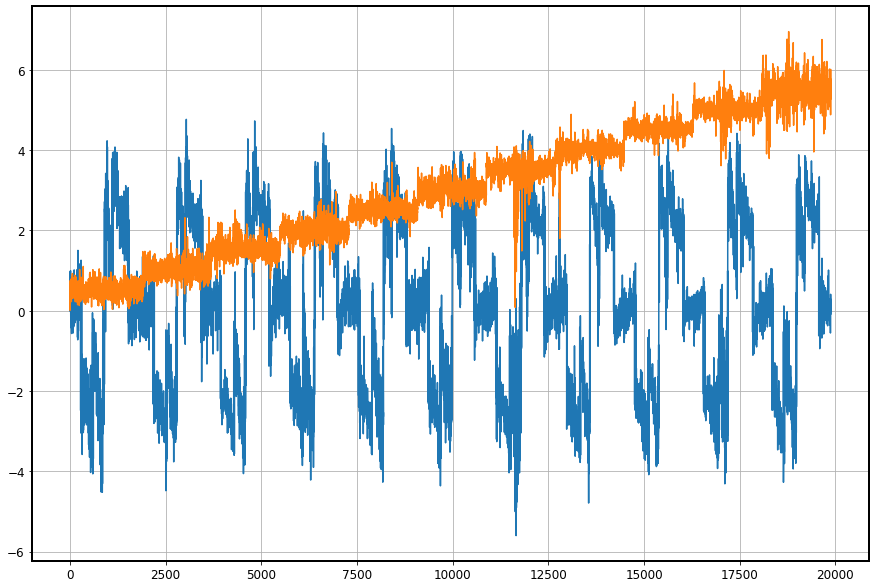

In [68]:
#y_pred = regr.predict(scaler.transform(X_test))
fig = plt.figure()
plt.plot(y_pred_full)
plt.grid()

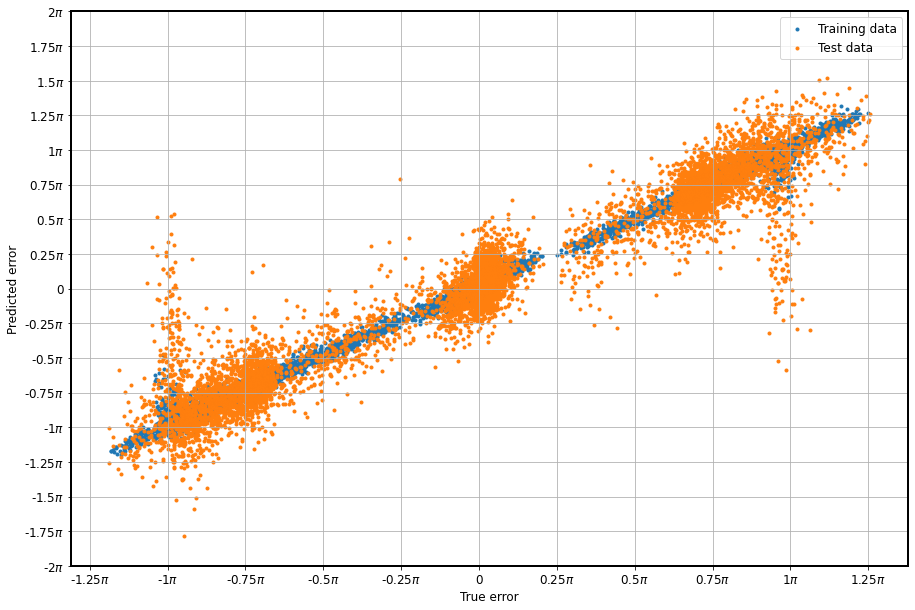

In [69]:
fig, ax = plt.subplots()#figsize=(30, 20))
#plt.scatter(y_test, y_pred)
plt.scatter(y_train.aoa_est_error, y_pred_train.aoa_est_error, marker='.', label='Training data')
plt.scatter(y_test.aoa_est_error, y_pred_test.aoa_est_error, marker='.', label='Test data')
plt.ylim(-2*np.pi, 2*np.pi)
axis_pi_formatter(ax.yaxis)
axis_pi_formatter(ax.xaxis)
plt.xlabel('True error')
plt.ylabel('Predicted error')
plt.legend()
plt.grid()

save_plot('mlp_regr_predicted_error')
plt.show()

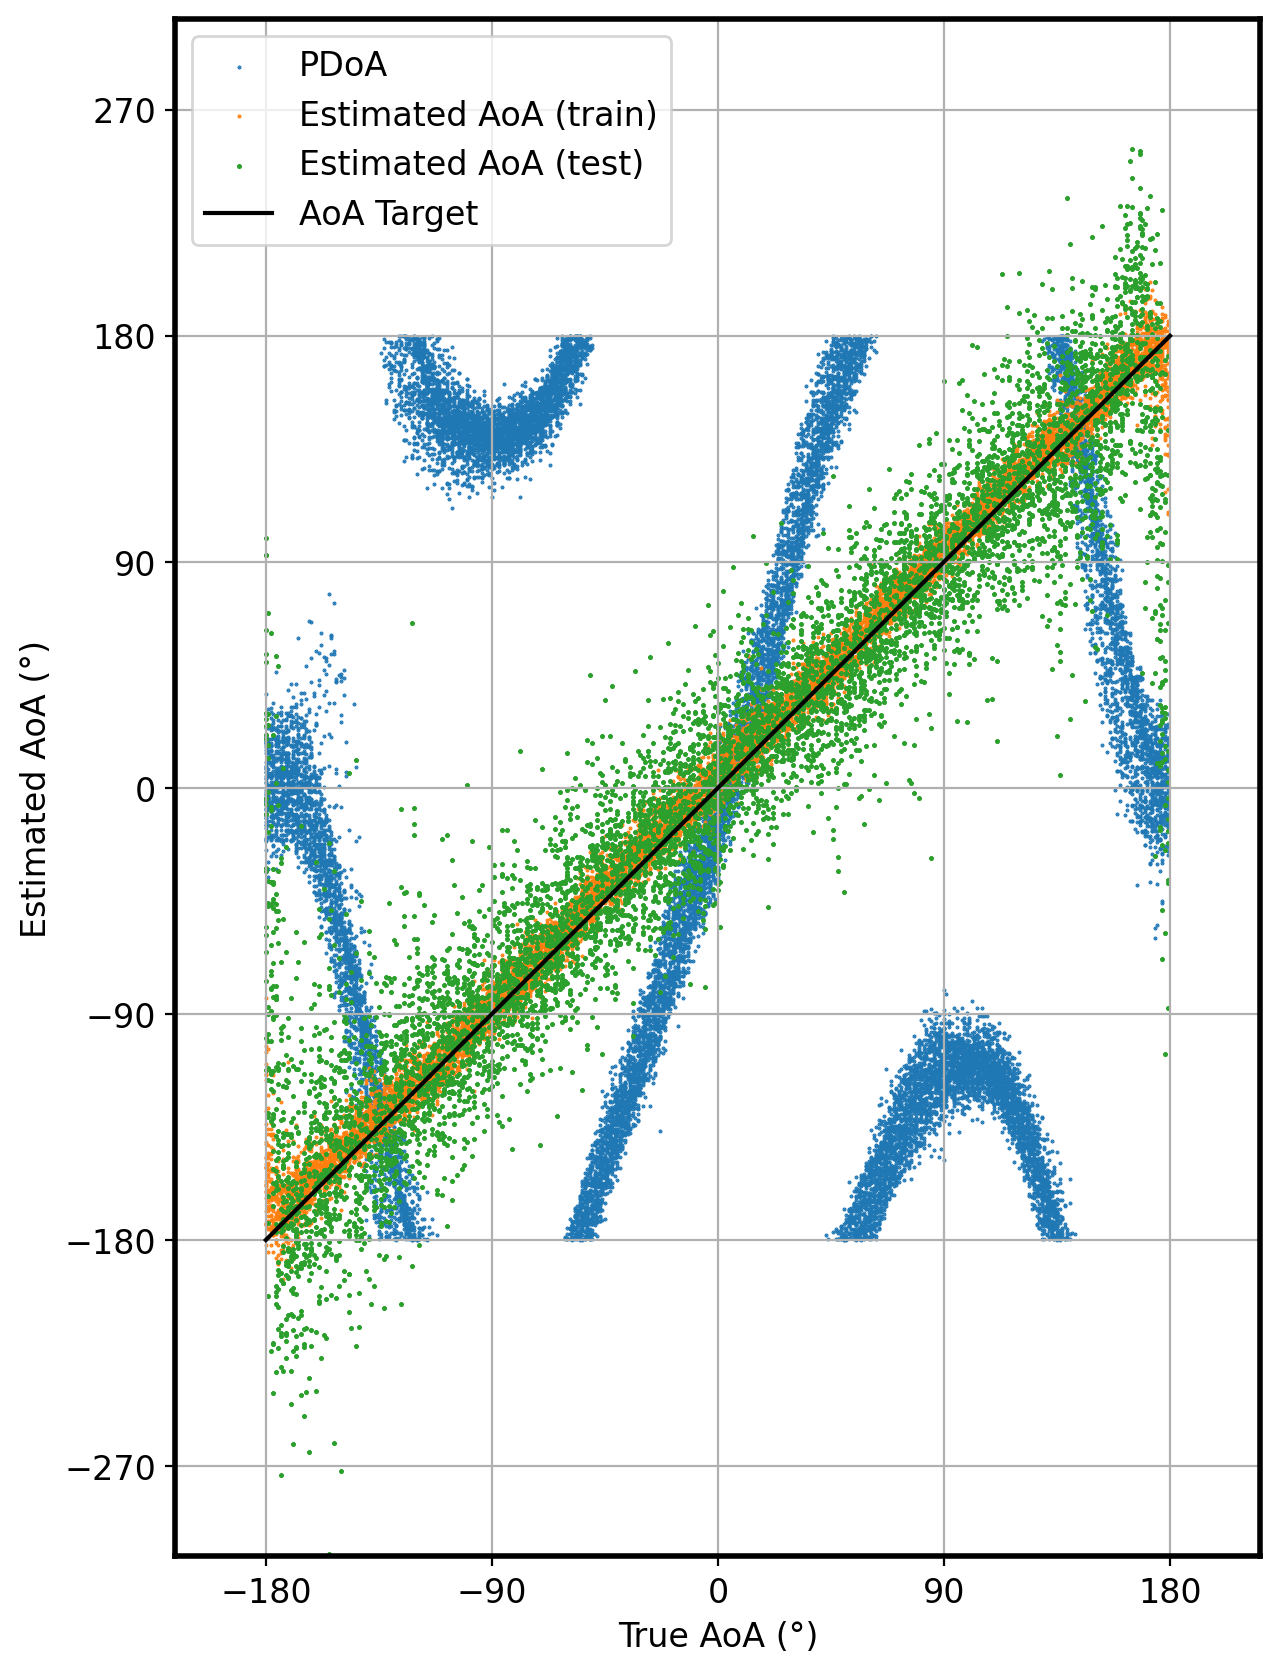

In [70]:
fig, ax = plt.subplots(figsize=(7, 10), dpi=200)

plt.scatter(np.rad2deg(data.rotation_rad), np.rad2deg(data.pdoa), marker='.', label='PDoA', s=0.8, color='tab:blue')

plt.scatter(np.rad2deg(meta_train.rotation_rad), np.rad2deg(meta_train.theta+y_pred_train.aoa_est_error), marker='.', s=0.8, label='Estimated AoA (train)', color='tab:orange')
plt.scatter(np.rad2deg(meta_test.rotation_rad), np.rad2deg(meta_test.theta+y_pred_test.aoa_est_error), marker='*', s=0.8, label='Estimated AoA (test)', color='tab:green')

plt.plot(np.rad2deg([-np.pi, np.pi]), np.rad2deg([-np.pi, np.pi]), label='AoA Target', color='black')

#rect = patches.Rectangle([-0.5*np.pi, -0.5*np.pi], np.pi, np.pi, edgecolor='red', facecolor='red', alpha=0.1, label='Direct AoA Estimation Possible')
#ax.add_patch(rect)
#rect = patches.Rectangle([-np.pi, -np.pi], 2*np.pi, 2*np.pi, edgecolor='green', facecolor='green', alpha=0.05, label='Total AoA Region')
#ax.add_patch(rect)

#axis_pi_formatter(ax.yaxis)
#axis_pi_formatter(ax.xaxis)

deg_ticks = [-270, -180, -90, 0, 90, 180, 270]
plt.xticks(deg_ticks)
plt.yticks(deg_ticks)

plt.grid()
plt.legend()

plt.ylim(np.rad2deg(-1.7*np.pi), np.rad2deg(1.7*np.pi))  # WARNING: this hides some extreme outliers
plt.xlim(np.rad2deg(-1.2*np.pi), np.rad2deg(1.2*np.pi))
ax.set_aspect(1)

#plt.title('AoA Error Estimation (ML)', fontsize='xx-large')
plt.xlabel('True AoA (°)')
plt.ylabel('Estimated AoA (°)')

save_plot('aoa_error_correction_regr (poster)')
plt.show()

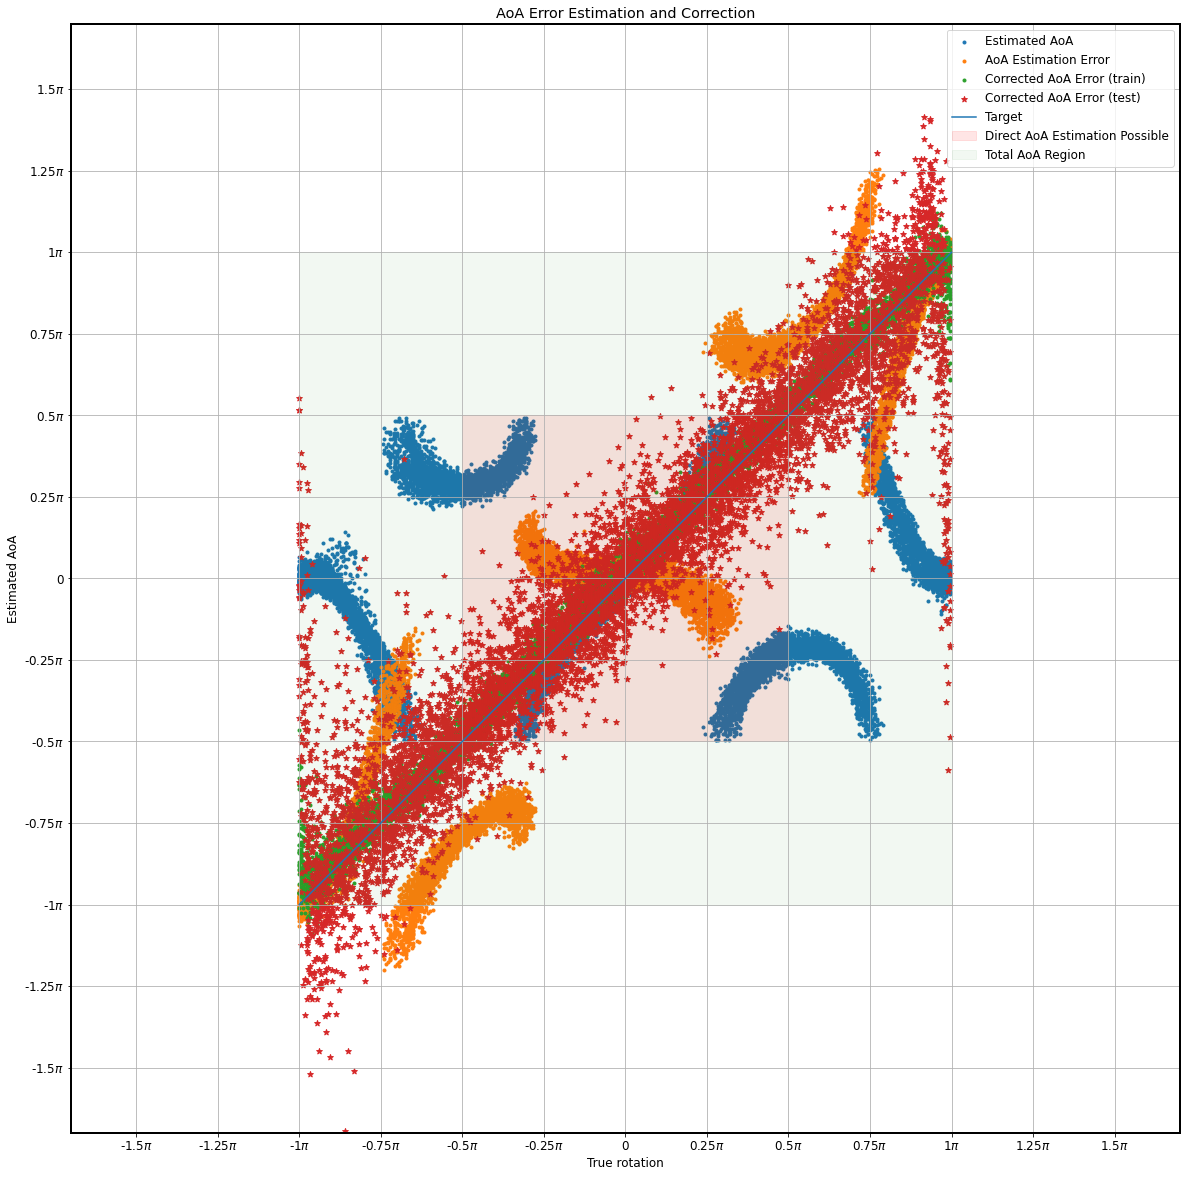

In [71]:
#fig, ax = plt.subplots(figsize=(15, 10))
fig, ax = plt.subplots(figsize=(30, 20))

plt.scatter(data.rotation_rad, data.theta, marker='.', label='Estimated AoA')

plt.scatter(data.rotation_rad, data.rotation_rad-data.theta, marker='.', label='AoA Estimation Error')

#plt.scatter(meta_train.rotation_rad, y_pred_train, marker='.', label='Predicted AoA Error (train)')
#plt.scatter(meta_test.rotation_rad, y_pred_test, marker='.', label='Predicted AoA Error (test)')
plt.scatter(meta_train.rotation_rad, meta_train.theta+y_pred_train.aoa_est_error, marker='.', label='Corrected AoA Error (train)')
plt.scatter(meta_test.rotation_rad, meta_test.theta+y_pred_test.aoa_est_error, marker='*', label='Corrected AoA Error (test)')

plt.plot([-np.pi, np.pi], [-np.pi, np.pi], label='Target')

rect = patches.Rectangle([-0.5*np.pi, -0.5*np.pi], np.pi, np.pi, edgecolor='red', facecolor='red', alpha=0.1, label='Direct AoA Estimation Possible')
ax.add_patch(rect)
rect = patches.Rectangle([-np.pi, -np.pi], 2*np.pi, 2*np.pi, edgecolor='green', facecolor='green', alpha=0.05, label='Total AoA Region')
ax.add_patch(rect)

axis_pi_formatter(ax.yaxis)
axis_pi_formatter(ax.xaxis)
plt.grid()
plt.legend()

plt.ylim(-1.7*np.pi, 1.7*np.pi)  # WARNING: this hides some extreme outliers
plt.xlim(-1.7*np.pi, 1.7*np.pi)
ax.set_aspect(1)

plt.title('AoA Error Estimation and Correction')
plt.xlabel('True rotation')
plt.ylabel('Estimated AoA')

save_plot('aoa_error_correction_regr')
plt.show()

In [74]:
mse = np.rad2deg(mean_squared_error(y.aoa_est_error, y_pred_full.aoa_est_error))
mae = np.rad2deg(mean_absolute_error(y.aoa_est_error, y_pred_full.aoa_est_error))
print(f'Full: MSE {mse:6.3f} deg, MAE {mae:6.3f} deg')

mse = np.rad2deg(mean_squared_error(y_train.aoa_est_error, y_pred_train.aoa_est_error))
mae = np.rad2deg(mean_absolute_error(y_train.aoa_est_error, y_pred_train.aoa_est_error))
print(f'Train: MSE {mse:6.3f} deg, MAE {mae:6.3f} deg')

mse = np.rad2deg(mean_squared_error(y_test.aoa_est_error, y_pred_test.aoa_est_error))
mae = np.rad2deg(mean_absolute_error(y_test.aoa_est_error, y_pred_test.aoa_est_error))
print(f'Test: MSE {mse:6.3f} deg, MAE {mae:6.3f} deg')

Full: MSE  9.603 deg, MAE 12.979 deg
Train: MSE  1.207 deg, MAE  6.030 deg
Test: MSE 20.915 deg, MAE 22.587 deg


In [75]:
def get_mse_mae(meta, pred, outliers):
    # meta contains all data, pred only a subset
    yy = (meta.theta+pred.aoa_est_error).dropna()
    xx = (meta.theta+meta.aoa_est_error).loc[yy.index]

    if outliers == 'discard':
        # remove outliers from prediction
        aa = xx
        xx = xx[(-np.pi < aa) & (aa < np.pi)]
        yy = yy[(-np.pi < aa) & (aa < np.pi)]
    elif outliers == 'wrap':
        xx = (xx+np.pi)%(2*np.pi)-np.pi
        yy = (yy+np.pi)%(2*np.pi)-np.pi
    else: # do nothing
        pass

    mse = np.rad2deg(mean_squared_error(xx, yy))
    mae = np.rad2deg(mean_absolute_error(xx, yy))
    return mse, mae

In [76]:
print('Error evaluation with no outlier handling:')

mse, mae = get_mse_mae(meta, y_pred_full, 'original')
print(f'Full: MSE {mse:6.3f} deg, MAE {mae:6.3f} deg')

mse, mae = get_mse_mae(meta, y_pred_train, 'original')
print(f'Train: MSE {mse:6.3f} deg, MAE {mae:6.3f} deg')

mse, mae = get_mse_mae(meta, y_pred_test, 'original')
print(f'Test: MSE {mse:6.3f} deg, MAE {mae:6.3f} deg')

Error evaluation with no outlier handling:
Full: MSE  9.603 deg, MAE 12.979 deg
Train: MSE  1.207 deg, MAE  6.030 deg
Test: MSE 20.915 deg, MAE 22.587 deg


In [78]:
print('Error evaluation if outliers are discarded:')

mse, mae = get_mse_mae(meta, y_pred_full, 'discard')
print(f'Full: MSE {mse:6.3f} deg, MAE {mae:6.3f} deg')

mse, mae = get_mse_mae(meta, y_pred_train, 'discard')
print(f'Train: MSE {mse:6.3f} deg, MAE {mae:6.3f} deg')

mse, mae = get_mse_mae(meta, y_pred_test, 'discard')
print(f'Test: MSE {mse:6.3f} deg, MAE {mae:6.3f} deg')

Error evaluation if outliers are discarded:
Full: MSE  8.820 deg, MAE 12.740 deg
Train: MSE  1.121 deg, MAE  5.950 deg
Test: MSE 19.084 deg, MAE 22.110 deg


In [79]:
print('Error evaluation if outliers are wrapped:')

mse, mae = get_mse_mae(meta, y_pred_full, 'wrap')
print(f'Full: MSE {mse:6.3f} deg, MAE {mae:6.3f} deg')

mse, mae = get_mse_mae(meta, y_pred_train, 'wrap')
print(f'Train: MSE {mse:6.3f} deg, MAE {mae:6.3f} deg')

mse, mae = get_mse_mae(meta, y_pred_test, 'wrap')
print(f'Test: MSE {mse:6.3f} deg, MAE {mae:6.3f} deg')

Error evaluation if outliers are wrapped:
Full: MSE 58.741 deg, MAE 20.799 deg
Train: MSE 24.848 deg, MAE  9.792 deg
Test: MSE 104.962 deg, MAE 35.963 deg


## Classification into 90 deg sectors

In [80]:
def get_classes(meta_df):
    classes = pd.DataFrame(index=meta_df.index, columns=['class'], dtype=int)
    # center: -45 to 45
    classes.loc[(meta_df.rotation_rad >= np.deg2rad(-45)) & (meta_df.rotation_rad < np.deg2rad(45)), 'class'] = 0
    # side 1: 45 to 135
    classes.loc[(meta_df.rotation_rad >= np.deg2rad(45)) & (meta_df.rotation_rad < np.deg2rad(135)), 'class'] = 1
    # back: 135 to 225 / -135
    classes.loc[(meta_df.rotation_rad >= np.deg2rad(135)) | (meta_df.rotation_rad < np.deg2rad(-135)), 'class'] = 2
    # side 225 to -45
    classes.loc[(meta_df.rotation_rad >= np.deg2rad(-135)) & (meta_df.rotation_rad < np.deg2rad(-45)), 'class'] = 3

    return classes.astype('int8')

In [81]:
y_cl = get_classes(meta)
y_train_cl = get_classes(meta_train)
y_test_cl = get_classes(meta_test)

In [82]:
y_train_cl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11779 entries, 11246 to 235
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   class   11779 non-null  int8 
dtypes: int8(1)
memory usage: 103.5 KB


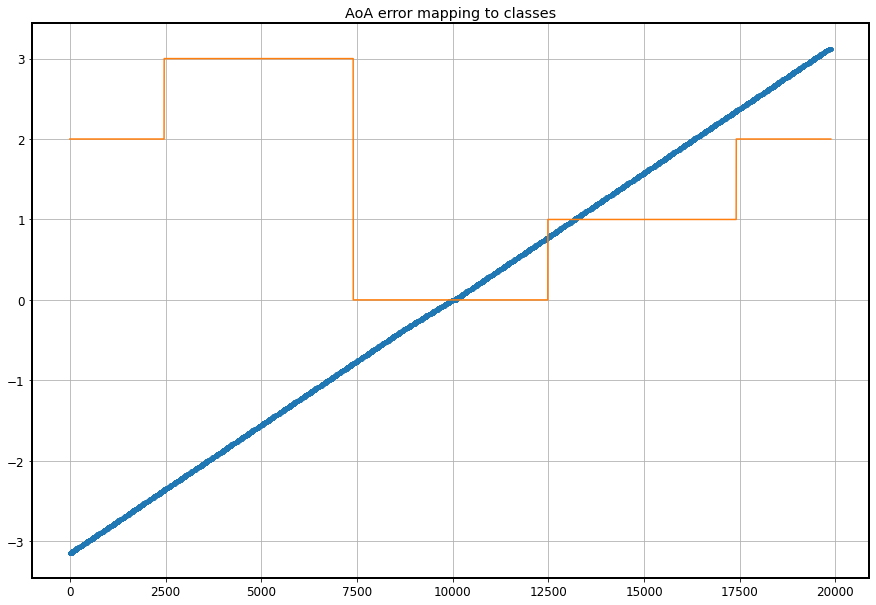

In [83]:
fig, ax = plt.subplots()
plt.plot(meta.loc[np.argsort(meta.rotation_rad), 'rotation_rad'].reset_index(drop=True), '.')
plt.plot(y_cl.loc[np.argsort(meta.rotation_rad)].reset_index(drop=True))
plt.grid()
plt.title(f'AoA error mapping to classes')
save_plot('aoa_classes')
plt.show()

In [84]:
%%time

#clf = MLPClassifier(random_state=1, max_iter=1000, hidden_layer_sizes=(224,), verbose=1)
clf = MLPClassifier(random_state=1, max_iter=1000, hidden_layer_sizes=(100,), verbose=1)

clf.fit(X_train_scaled, y_train_cl.values.ravel())
save_model(clf, 'mlp_classifier_100')

#clf = load_model('mlp_classifier')

clf

Iteration 1, loss = 1.15234916
Iteration 2, loss = 0.89734021
Iteration 3, loss = 0.73316999
Iteration 4, loss = 0.60802131
Iteration 5, loss = 0.51079650
Iteration 6, loss = 0.43385951
Iteration 7, loss = 0.37763582
Iteration 8, loss = 0.33177536
Iteration 9, loss = 0.29571901
Iteration 10, loss = 0.26667180
Iteration 11, loss = 0.24209600
Iteration 12, loss = 0.22234146
Iteration 13, loss = 0.20400258
Iteration 14, loss = 0.18898158
Iteration 15, loss = 0.17683764
Iteration 16, loss = 0.16484617
Iteration 17, loss = 0.15346642
Iteration 18, loss = 0.14657655
Iteration 19, loss = 0.13661678
Iteration 20, loss = 0.13189078
Iteration 21, loss = 0.12412182
Iteration 22, loss = 0.11759175
Iteration 23, loss = 0.11287131
Iteration 24, loss = 0.10748839
Iteration 25, loss = 0.10452723
Iteration 26, loss = 0.09855880
Iteration 27, loss = 0.09437325
Iteration 28, loss = 0.09146169
Iteration 29, loss = 0.08847224
Iteration 30, loss = 0.08541610
Iteration 31, loss = 0.08215851
Iteration 32, los

MLPClassifier(max_iter=1000, random_state=1, verbose=1)

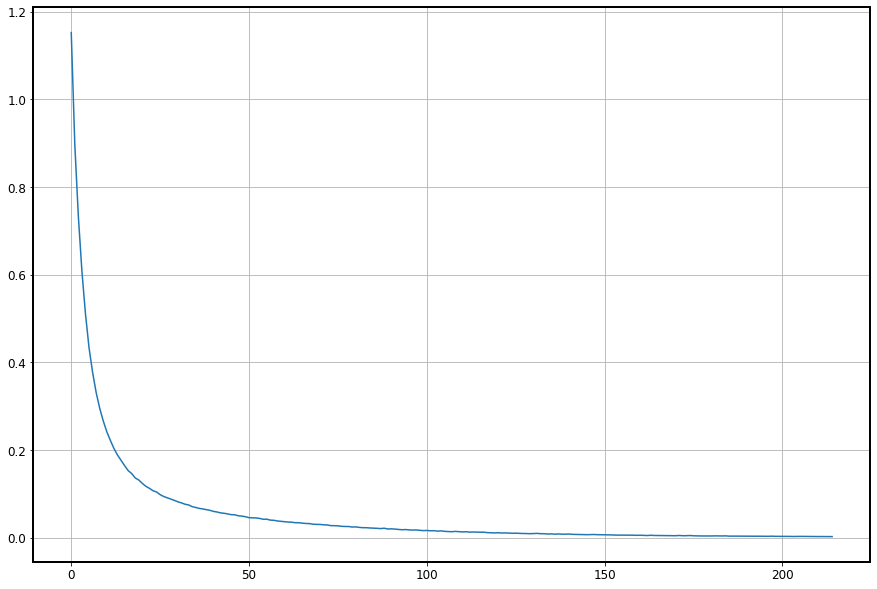

In [85]:
plt.figure()
plt.plot(clf.loss_curve_)
#plt.ylim(0, 1)
plt.grid()

save_plot('mlp_90deg_clf_loss_curve')
plt.show()

In [87]:
y_pred_train_cl = clf.predict(scaler.transform(X_train))
y_pred_test_cl = clf.predict(scaler.transform(X_test))

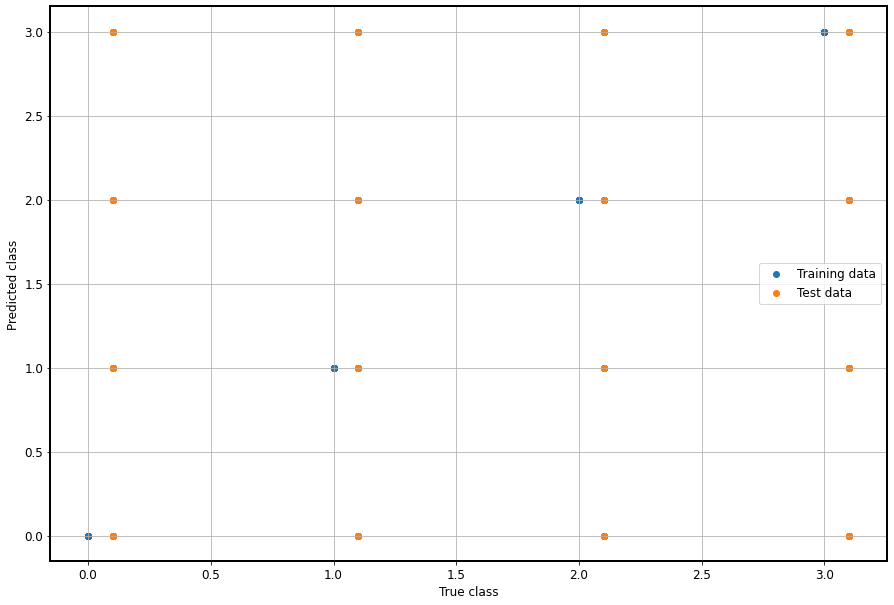

In [88]:
fig, ax = plt.subplots()#figsize=(30, 20))

plt.scatter(y_train_cl, y_pred_train_cl, label='Training data')
plt.scatter(y_test_cl+0.1, y_pred_test_cl, label='Test data')

plt.xlabel('True class')
plt.ylabel('Predicted class')
plt.legend()
plt.grid()

#save_plot('mlp_clf_aoa_predicted_error')
plt.show()

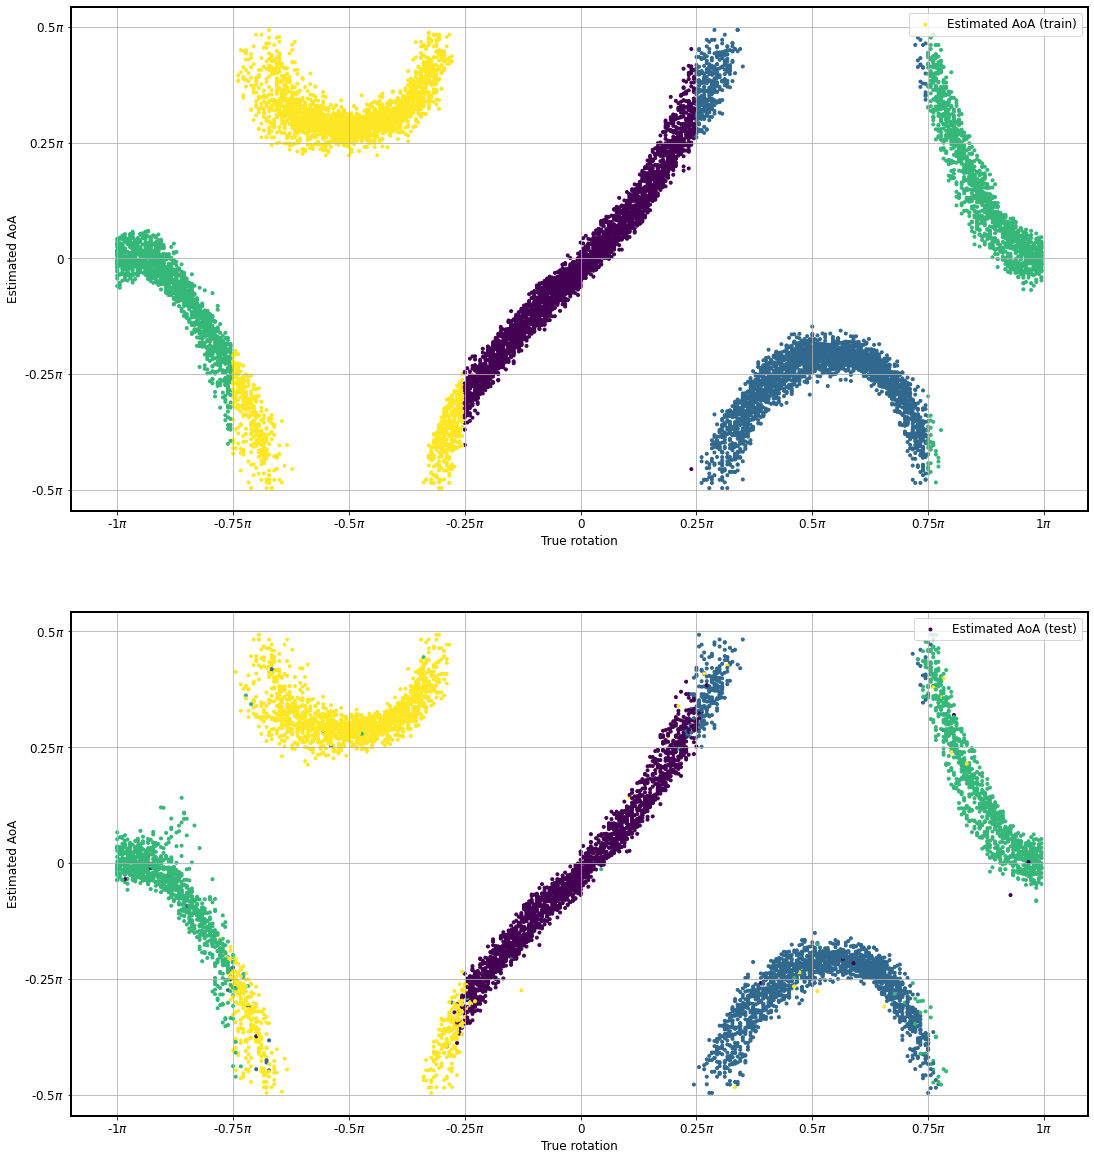

In [90]:
#fig, ax = plt.subplots(figsize=(15, 10))
#fig, ax = plt.subplots(figsize=(30, 20))
fig, ax = plt.subplots(2, 1, figsize=(30, 20))

def format_plot(ax):
    axis_pi_formatter(ax.yaxis)
    axis_pi_formatter(ax.xaxis)
    ax.grid()
    ax.legend(loc='upper right')
    ax.set_aspect(1)
    ax.set_xlabel('True rotation')
    ax.set_ylabel('Estimated AoA')

ax[0].scatter(meta_train.rotation_rad, meta_train.theta, c=y_pred_train_cl, marker='.', label='Estimated AoA (train)')
format_plot(ax[0])
ax[1].scatter(meta_test.rotation_rad, meta_test.theta, c=y_pred_test_cl, marker='.', label='Estimated AoA (test)')
format_plot(ax[1])

save_plot('mlp_90deg_clf_prediction')
plt.show()

In [91]:
accuracy_score(y_train_cl, y_pred_train_cl), accuracy_score(y_test_cl, y_pred_test_cl)

(1.0, 0.9710764587525151)

In [92]:
precision_score(y_train_cl, y_pred_train_cl, average=None), recall_score(y_train_cl, y_pred_train_cl, average=None), precision_score(y_train_cl, y_pred_train_cl, average='micro'), recall_score(y_train_cl, y_pred_train_cl, average='micro')

(array([1., 1., 1., 1.]), array([1., 1., 1., 1.]), 1.0, 1.0)

(array([1., 1., 1., 1.]), array([1., 1., 1., 1.]), 1.0, 1.0)

In [93]:
precision_score(y_test_cl, y_pred_test_cl, average=None), recall_score(y_test_cl, y_pred_test_cl, average=None), precision_score(y_test_cl, y_pred_test_cl, average='micro'), recall_score(y_test_cl, y_pred_test_cl, average='micro')

(array([0.97260274, 0.97043833, 0.96838936, 0.97286226]),
 array([0.97403234, 0.9709332 , 0.96984925, 0.96938776]),
 0.9710764587525151,
 0.9710764587525151)